In [3]:
# Run some setup code for this notebook.

from __future__ import print_function
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
from keras.datasets import cifar10
from keras.layers import Reshape, Dense, Conv2D, Flatten, MaxPool2D, Dropout, BatchNormalization, UpSampling2D
from keras.models import Sequential
import numpy as np
from matplotlib import pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (15,5)



Using TensorFlow backend.


### Dataset
Let's load the cifar dataset and examine what it is

In [4]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

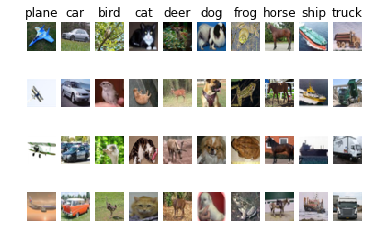

In [5]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 4
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(x_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)

In [6]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('Max of x:', np.max(x_train), '\nMax of y:', np.max(y_train))

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
Max of x: 255 
Max of y: 9


There are 50000 images in train, each image of size (32, 32, 3).

There are 10 classes of images and each image has a max of 255 pixel value


Let's create a CNN Autoencoder

In [7]:
model = Sequential()
model.add(Conv2D(16, (5, 5), input_shape=((32, 32, 3)), padding='same', activation='relu'))
model.add(MaxPool2D((2,2), padding='same'))
model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(MaxPool2D((2,2), padding='same'))
model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(UpSampling2D((2,2)))
model.add(Conv2D(16, (5,5), padding='same', activation='relu'))
model.add(UpSampling2D((2,2)))
model.add(Conv2D(3, (5,5), padding='same', activation='sigmoid'))

In [8]:
model.compile(optimizer='adam', loss='binary_crossentropy')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 16)        1216      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 32)          9248      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 16)        12816     
__________

#### Notice that we standardize the image as `x_train/255.0` during input feed

In [9]:
from keras.callbacks import ReduceLROnPlateau
lrs = ReduceLROnPlateau(verbose=1, epsilon=0.01)
model.fit(x_train/255.0, x_train/255.0, epochs=10, callbacks=[lrs], validation_split=0.1)

C:\anaconda3\lib\site-packages\keras\callbacks.py:999: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Train on 45000 samples, validate on 5000 samples
Epoch 1/10
45000/45000 [==============================] - 2364s 53ms/step - loss: 0.5700 - val_loss: 0.5638
Epoch 2/10
45000/45000 [==============================] - 2896s 64ms/step - loss: 0.5605 - val_loss: 0.5617
Epoch 3/10
45000/45000 [==============================] - 2185s 49ms/step - loss: 0.5589 - val_loss: 0.5600
Epoch 4/10
25632/45000 [================>.............] - ETA: 38:30 - loss: 0.5578

KeyboardInterrupt: 

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
n = np.random.randint(0, high=50000)
x_pred = model.predict(np.array([x_train[n]/255.0]), verbose=0)
x_pred.shape
# 121 stands for (1 row, 2 columns, 1st plot in the grid)
plt.subplot(121)
plt.imshow((x_pred[0]*255.0).astype('uint8'))
plt.grid('off')
plt.axis('off')
plt.title('Reconstructed Image')
# 121 stands for (1 row, 2 columns, 2nd plot in the grid)
plt.subplot(122)
plt.imshow(x_train[n].astype('uint8'))
plt.grid('off')
plt.axis('off')
plt.title('Original Image')

## Denoising Convolution Auto Encoders
Now we shall create an image dataset where random squares in images are removed.
The autoencoder learns to fill these patches.

In [ ]:
def crop_image(inp_img):
    crop_img = inp_img.copy()
    x1 = np.random.randint(0, 15)
    delta = np.random.randint(5, 10)
    y1 = np.random.randint(0, 15)
    crop_img[x1:x1+delta,y1:y1+delta,:] = 0.5
    return(crop_img)
    


#### Let's plot a random image and a clipped version of it

In [ ]:
n = np.random.randint(0, high=50000)

x_orig = x_train[n]
x_crop = crop_image(x_orig)
plt.subplot(121)
plt.imshow(x_orig, cmap='gray_r')
plt.grid('off')
plt.axis('off')
plt.title('Original Image')

plt.subplot(122)
plt.imshow(x_crop, cmap='gray_r')
plt.grid('off')
plt.axis('off')
plt.title('Cropped Image')

In [ ]:
## Dataset creation
x_cropped = np.array(map(crop_image, x_train))

In [ ]:
x_cropped.shape, x_train.shape

In [ ]:
## Model training
## We shall continue training from the previous autoencoder.
model.fit(x_cropped/255.0, x_train/255.0, epochs=5, callbacks=[lrs], validation_split=0.1)

In [ ]:
plt.rcParams['figure.figsize'] = (15, 5)
n = np.random.randint(0, high=50000)
x_pred = model.predict(np.array([x_cropped[n]/255.0]), verbose=0)
x_pred.shape
plt.subplot(151)
plt.imshow(x_train[n])
plt.grid('off')
plt.axis('off')
plt.title('Original Image')
plt.subplot(153)
plt.imshow(x_cropped[n])
plt.grid('off')
plt.axis('off')
plt.title('Cropped Image')
plt.subplot(155)
plt.imshow((x_pred[0]*255.0).astype('uint8'))
plt.grid('off')
plt.axis('off')
plt.title('Reconstructed Image')

